In [0]:
#@title Copyright 2019 The Empirical Calibration Authors.
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ============================================================================


# Causal Inference of Lalonde

<table align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/google/empirical_calibration/blob/master/notebooks/causal_inference_lalonde.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/google/empirical_calibration/blob/master/notebooks/causal_inference_lalonde.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
</table>

>[Causal Inference of Lalonde](#scrollTo=at-UGrku-nOR)

>>[Background](#scrollTo=elFMgW4wr7Dn)

>>[Imports](#scrollTo=aUBsEiG8mNd2)

>>[Data](#scrollTo=vEpwsBMGYNc7)

>>>[Experiment benchmark](#scrollTo=tqfLgPXsmxps)

>>>>[Difference Estimator](#scrollTo=lNcbasXRxb2s)

>>>>[Regression Estimator](#scrollTo=NwTjJpCawumH)

>>>[Observational controls](#scrollTo=C9L8BZJux89B)

>>[Empirical Calibration](#scrollTo=3cqeVQRduHSv)

>>>[Prepare Balancing Constraints](#scrollTo=l_T8GZvEo3Un)

>>>[Entropy Balancing](#scrollTo=XcOC7mKlpKC9)

>>>[Quadratic Balancing](#scrollTo=vLijOb5cdpjd)

>>>[Imposing an Upper Bound on Weights](#scrollTo=ToPPJFopDrEL)



We illustrate the use of empirical calibration on the observational part of the LaLonde data to evaluate the effect of a job training program.



## Background

The [LaLonde (1986)](http://people.hbs.edu/nashraf/LaLonde_1986.pdf) data is a
canonical benchmark in the causal inference literature. It consists of three
groups for evaluating the effect of a large scale job training program — the
National Supported Work Demonstration (NSW):

*   An experimental treatment group with 185 observations.
*   An experimental control group with 260 observations.
*   An observational control group drawn from the Current Population Survey
    (CPS), with 15,992 observations.

The outcome variable is the post-intervention earnings in 1978. The following
pre-intervention covariates are available for all three groups.

Name         | Description
------------ | ---------------------------------------------------
age          | age.
education    | years of schooling.
black        | 1 if black, 0 otherwise.
hispanic     | 1 if hispanic, 0 otherwise.
married      | 1 if married, 0 otherwise.
nodegree     | 1 if not completed high school degree, 0 otherwise.
earnings1974 | pre-intervention earnings in 1974.
earnings1975 | pre-intervention earnings in 1975.


## Imports

In [0]:
import numpy as np
import pandas as pd
import patsy
import seaborn as sns
import statsmodels.api as sm

# install and import ec
!pip install -q git+https://github.com/google/empirical_calibration
import empirical_calibration as ec

sns.set_style('whitegrid')
%config InlineBackend.figure_format='retina'
%precision 3

## Data

The data are downloaded from
[Dehejia and Wahba (1999)](http://www.uh.edu/~adkugler/Dehejia&Wahba_JASA.pdf)'s
data hosting [website](https://users.nber.org/~rdehejia/data) via functions
under `ec.data.lalonde`.

### Experiment benchmark

The first column is the treatment assignment. The last column is the post-intervention outcome variable. The remaining 8 columns are pre-intervention covariates.

In [0]:
#@title experimentl treatment group
treated = ec.data.lalonde.experimental_treated()
treated.head()

,treatment,age,education,black,hispanic,married,nodegree,earnings1974,earnings1975,earnings1978
0,1.0,37.0,11.0,1.0,0.0,1.0,1.0,0.0,0.0,9930.0460
1,1.0,22.0,9.0,0.0,1.0,0.0,1.0,0.0,0.0,3595.8940
2,1.0,30.0,12.0,1.0,0.0,0.0,0.0,0.0,0.0,24909.4500
3,1.0,27.0,11.0,1.0,0.0,0.0,1.0,0.0,0.0,7506.1460
4,1.0,33.0,8.0,1.0,0.0,0.0,1.0,0.0,0.0,289.7899


In [0]:
#@title experimental control group
control = ec.data.lalonde.experimental_control()
control.head()

,treatment,age,education,black,hispanic,married,nodegree,earnings1974,earnings1975,earnings1978
0,0.0,23.0,10.0,1.0,0.0,0.0,1.0,0.0,0.0,0.00
1,0.0,26.0,12.0,0.0,0.0,0.0,0.0,0.0,0.0,12383.68
2,0.0,22.0,9.0,1.0,0.0,0.0,1.0,0.0,0.0,0.00
3,0.0,18.0,9.0,1.0,0.0,0.0,1.0,0.0,0.0,10740.08
4,0.0,45.0,11.0,1.0,0.0,0.0,1.0,0.0,0.0,11796.47


We use two methods to estimate the average treatment effects on the treated.



#### Difference Estimator

Using a simple difference in means, we estimate that the program increased the average earnings of the treated by $1794.

In [0]:
diff = treated["earnings1978"].mean() - control["earnings1978"].mean()
diff

1794.342

Using the estimator for the sampling variance (see formula 6.18 of [Imbens and Rubin (2014)](http://www.jakebowers.org/ITVExperiments/imbensrubin6.pdf)), we estimate the 95% $z$-interval of the difference as **`[479, 3109]`**.

In [0]:
sd = np.sqrt(
    treated["earnings1978"].var(ddof=1) / len(treated["earnings1978"]) +
    control["earnings1978"].var(ddof=1) / len(control["earnings1978"]))
sd

670.997

#### Regression Estimator
The experimental treated and experimental control group are not perfectly balanced.

In [0]:
df = pd.concat([treated, control])
print(df.groupby("treatment").mean().T)

treatment             0.0          1.0
age             25.053846    25.816216
education       10.088462    10.345946
black            0.826923     0.843243
hispanic         0.107692     0.059459
married          0.153846     0.189189
nodegree         0.834615     0.708108
earnings1974  2107.026658  2095.573689
earnings1975  1266.909002  1532.055314
earnings1978  4554.801126  6349.143530


Thus, we can fit a linear outcome regression model to "clean up" the imbalance. It yields an estimated average treatment effect on the treated of **`$1698`** with a slightly more efficient 95% confidence interval **`[458, 2938]`**.

In [0]:
lm = sm.OLS(df["earnings1978"], df.iloc[:, :-1])
print(lm.fit().summary())

                            OLS Regression Results                            
Dep. Variable:           earnings1978   R-squared:                       0.424
Model:                            OLS   Adj. R-squared:                  0.412
Method:                 Least Squares   F-statistic:                     35.62
Date:                Thu, 11 Jul 2019   Prob (F-statistic):           4.51e-47
Time:                        16:09:58   Log-Likelihood:                -4534.2
No. Observations:                 445   AIC:                             9086.
Df Residuals:                     436   BIC:                             9123.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
treatment     1698.3166    630.972      2.692   

### Observational controls

In [0]:
control = ec.data.lalonde.observational_control()
control.head()

,treatment,age,education,black,hispanic,married,nodegree,earnings1974,earnings1975,earnings1978
0,0.0,45.0,11.0,0.0,0.0,1.0,1.0,21516.670,25243.550,25564.670
1,0.0,21.0,14.0,0.0,0.0,0.0,0.0,3175.971,5852.565,13496.080
2,0.0,38.0,12.0,0.0,0.0,1.0,0.0,23039.020,25130.760,25564.670
3,0.0,48.0,6.0,0.0,0.0,1.0,1.0,24994.370,25243.550,25564.670
4,0.0,18.0,8.0,0.0,0.0,1.0,1.0,1669.295,10727.610,9860.869


We create two additional indicators `umemployed1974` and `umemployed1975` based on the earnings.

In [0]:
treated["unemployed1974"] = treated["earnings1974"] == 0
treated["unemployed1975"] = treated["earnings1975"] == 0
control["unemployed1974"] = control["earnings1974"] == 0
control["unemployed1975"] = control["earnings1975"] == 0

The observational control group is significantly different from the experimental treatment group.

In [0]:
df = pd.concat([treated, control])
print(df.groupby("treatment").mean().T)

treatment                0.0          1.0
age                33.225238    25.816216
education          12.027514    10.345946
black               0.073537     0.843243
hispanic            0.072036     0.059459
married             0.711731     0.189189
nodegree            0.295835     0.708108
earnings1974    14016.800304  2095.573689
earnings1975    13650.803376  1532.055314
earnings1978    14846.659673  6349.143530
unemployed1974      0.119622     0.708108
unemployed1975      0.109305     0.600000


The experimental treated subjects tend to be younger, with less education, black, single, without high school degree, and have smaller pre-intervention earnings.

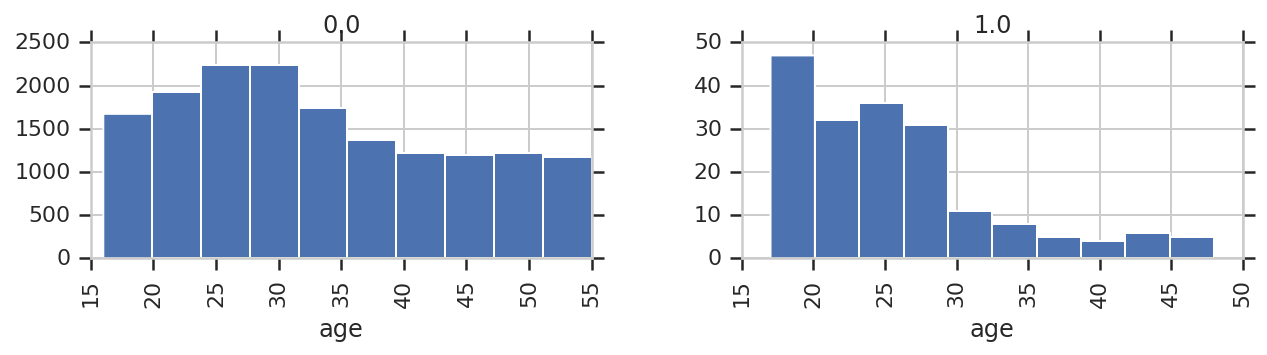

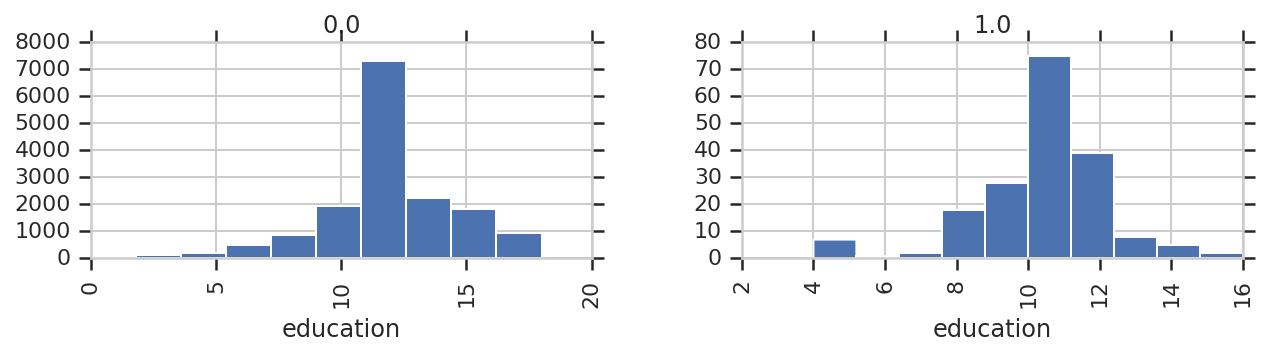

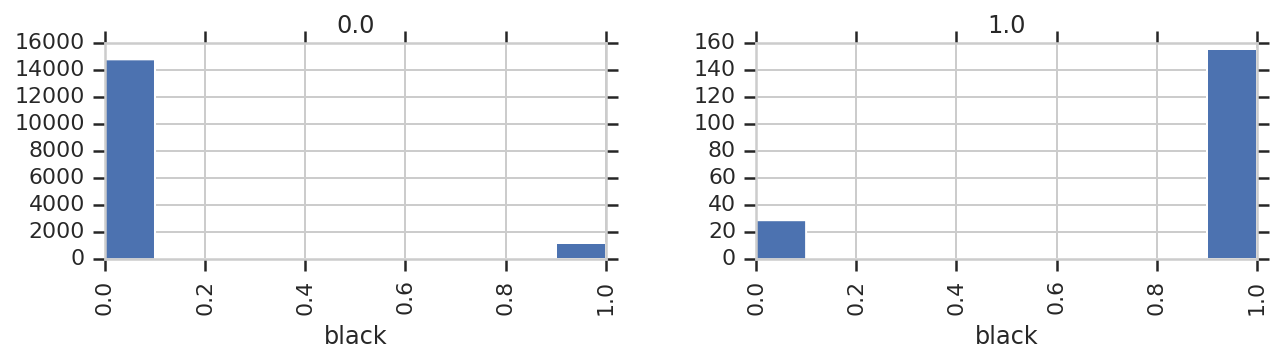

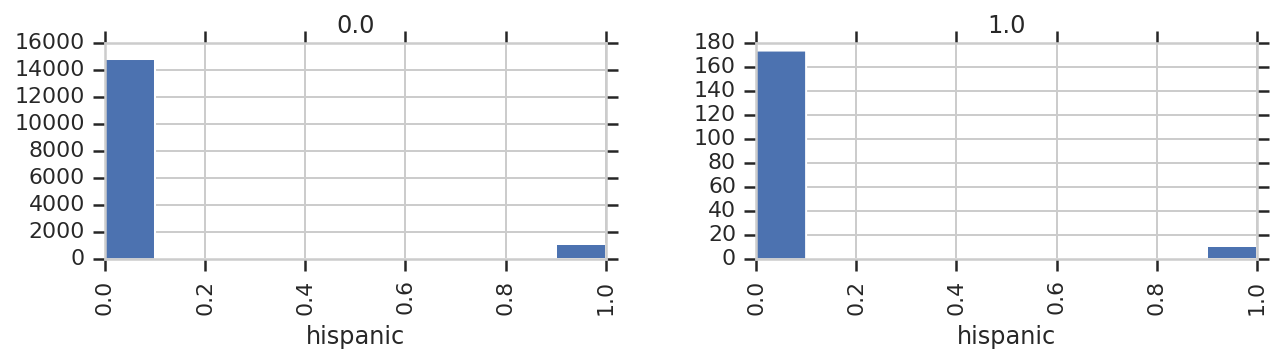

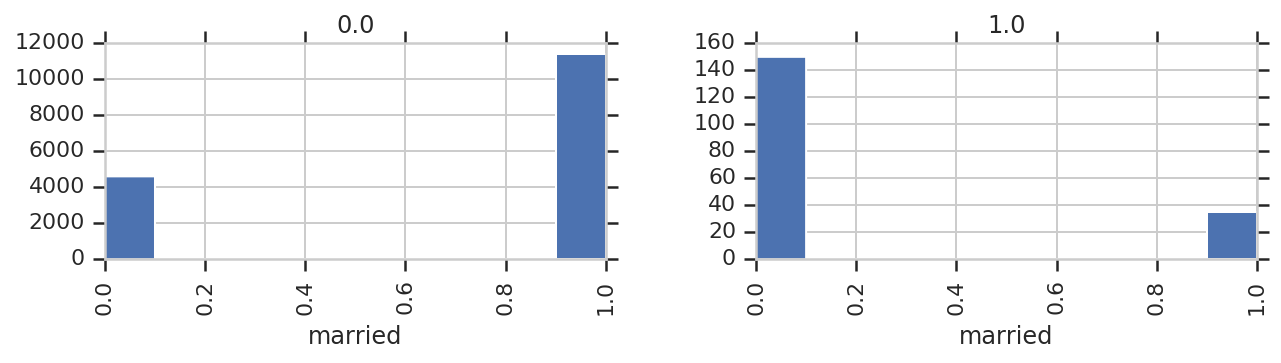

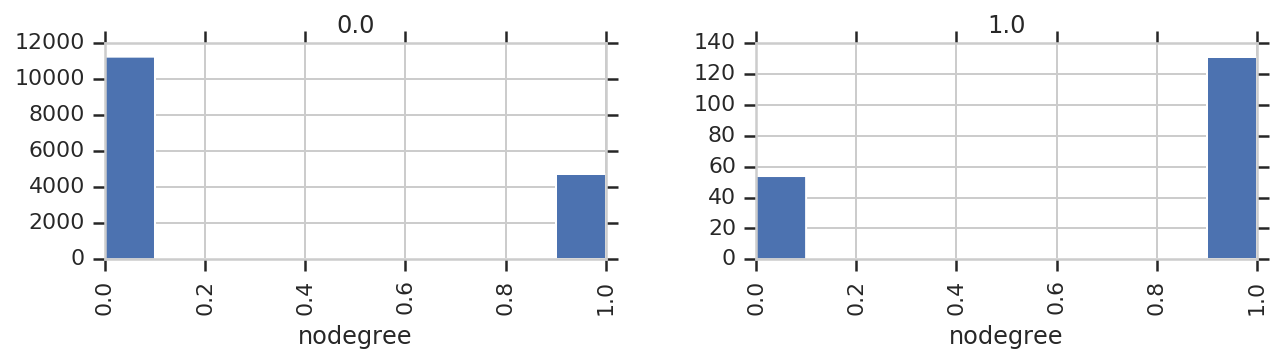

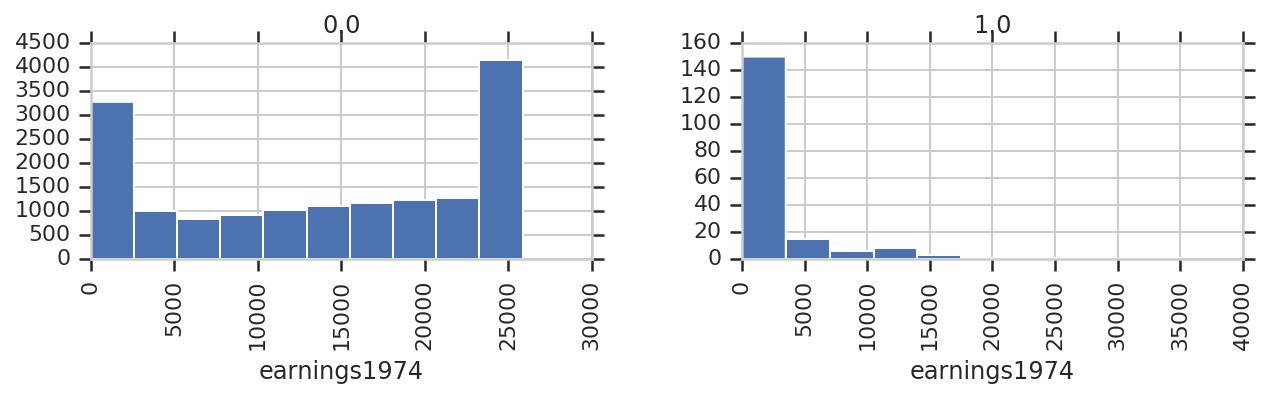

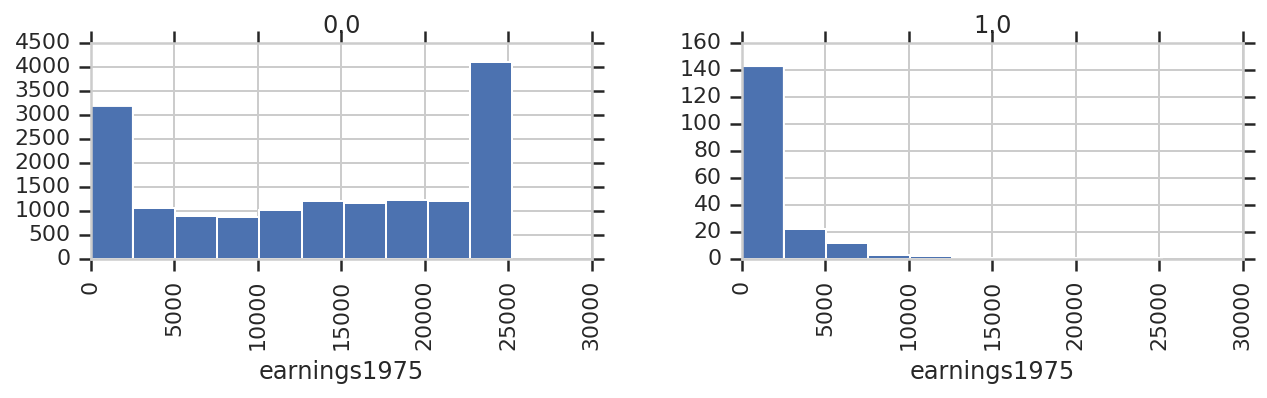

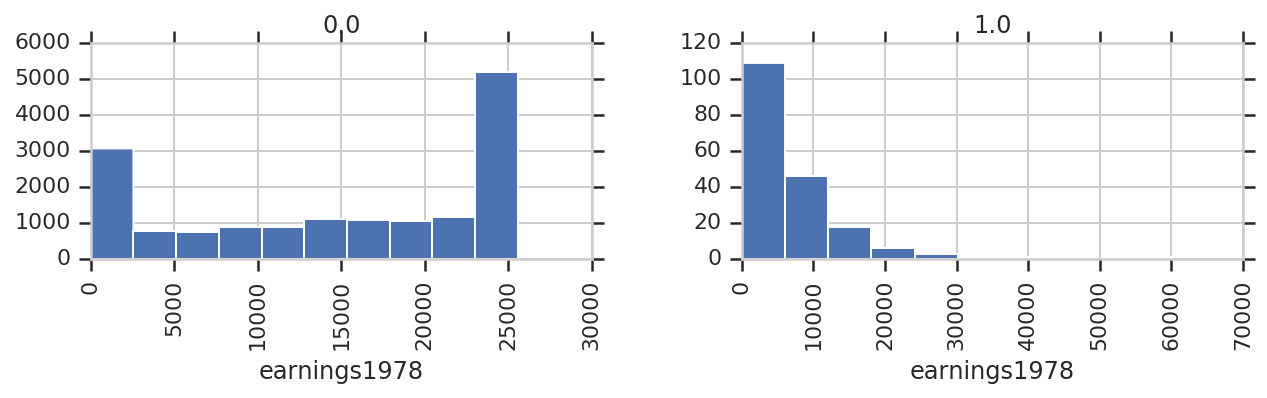

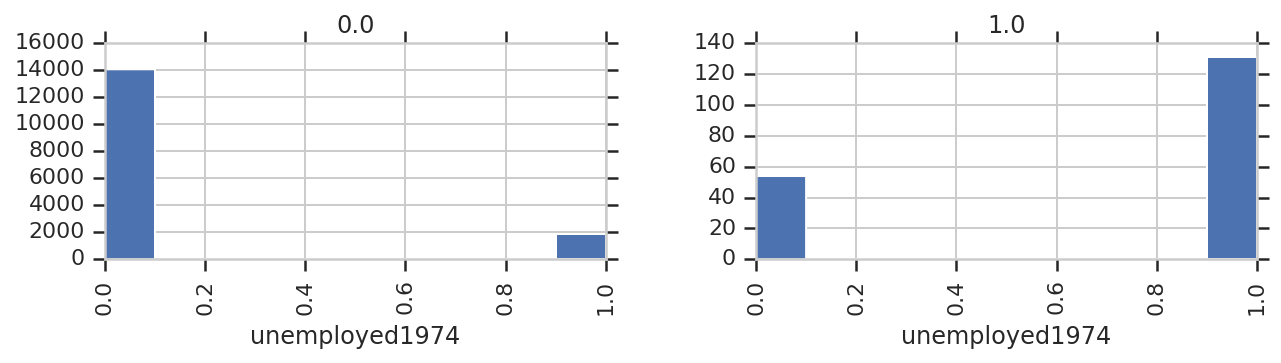

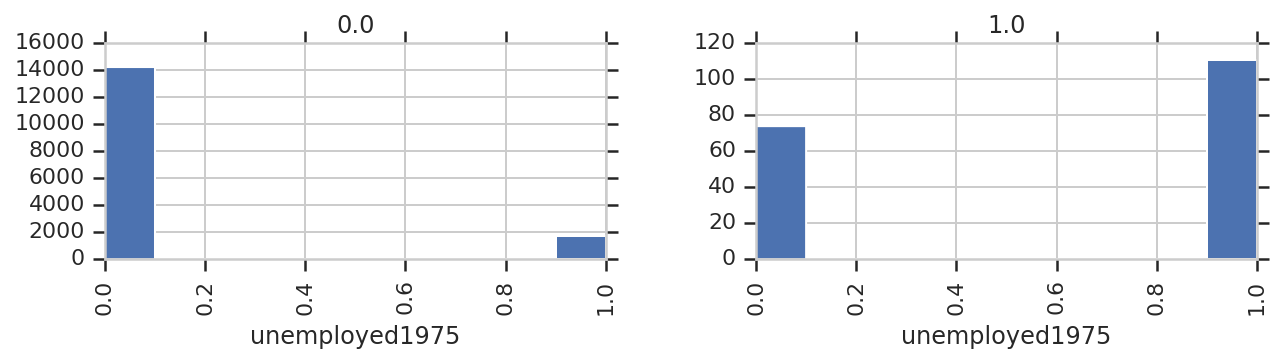

In [0]:
for name in df.columns[1:]:
  axes = df.hist(column=name, by=df["treatment"], figsize=(10, 2))
  axes[0].set_xlabel(name)
  axes[1].set_xlabel(name)

## Empirical Calibration

Empirical calibration assigns weights to the observational control subjects such that the reweighted control group equates the treated group on moments of covariates. The weights are also sought to be as uniform as possible.

### Prepare Balancing Constraints

There are 8 raw pre-intervention covariates. Simply balancing on their first moment might not be sufficient. We follow [Hainmueller (2011)](https://web.stanford.edu/~jhain/Paper/PA2012.pdf)'s analysis and consider a total of 52 balancing constraints, which include single terms, selected one-way interactions, and selected squared terms. Note that balancing on all 52 transformed covariates might be excessive, we choose them simply to reproduce Hainmueller's results.

We use [`patsy`](https://patsy.readthedocs.io/en/v0.1.0/index.html)'s formula API to construct the covariate matrices, where "`:`" indicates interaction, and "`-`" means removes the term on the right.

In [0]:
formula = (
    "(age + education + black + hispanic + married + nodegree + earnings1974 +"
    " earnings1975 + unemployed1974 + unemployed1975)**2 + I(age**2) + "
    "I(education**2) - black:hispanic - education:nodegree - "
    "earnings1974:earnings1975 - earnings1974:unemployed1974 - "
    "earnings1975:unemployed1975"
)

In [0]:
treated2 = patsy.dmatrix(formula, treated, return_type="dataframe").iloc[:, 1:]
control2 = patsy.dmatrix(formula, control, return_type="dataframe").iloc[:, 1:]

The full list of the 52 balancing constraints is shown below.

In [0]:
for i, name in enumerate(control2.columns):
  print("%s: %s" % (i, name))

0: unemployed1974[T.True]
1: unemployed1975[T.True]
2: unemployed1974[T.True]:unemployed1975[T.True]
3: age
4: age:unemployed1974[T.True]
5: age:unemployed1975[T.True]
6: education
7: education:unemployed1974[T.True]
8: education:unemployed1975[T.True]
9: black
10: black:unemployed1974[T.True]
11: black:unemployed1975[T.True]
12: hispanic
13: hispanic:unemployed1974[T.True]
14: hispanic:unemployed1975[T.True]
15: married
16: married:unemployed1974[T.True]
17: married:unemployed1975[T.True]
18: nodegree
19: nodegree:unemployed1974[T.True]
20: nodegree:unemployed1975[T.True]
21: earnings1974
22: earnings1974:unemployed1975[T.True]
23: earnings1975
24: earnings1975:unemployed1974[T.True]
25: age:education
26: age:black
27: age:hispanic
28: age:married
29: age:nodegree
30: age:earnings1974
31: age:earnings1975
32: education:black
33: education:hispanic
34: education:married
35: education:earnings1974
36: education:earnings1975
37: black:married
38: black:nodegree
39: black:earnings1974
40:

### Entropy Balancing

We first use the default `ENTROPY` objective which mimizes the [Kullback-Leibler](https://en.wikipedia.org/wiki/Kullback%E2%80%93Leibler_divergence) divergence between the balancing weights and uniform weights.

In [0]:
weights, success = ec.calibrate(covariates=control2.values,
                                target_covariates=treated2.values)
success

False

It turns out that we need to relax the equality constraint a tiny bit to ensure convergence.

In [0]:
weights, success = ec.calibrate(covariates=control2.values,
                                target_covariates=treated2.values,
                                l2_norm=1e-5)
success

True

Top 3 control observations account for 12% of total weight.

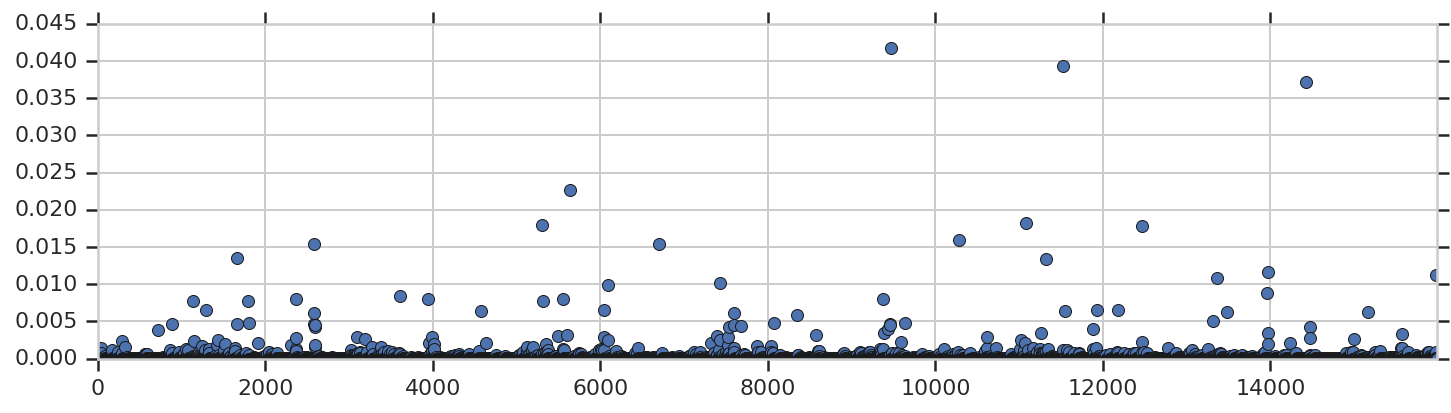

In [0]:
pd.Series(weights).plot(style='o', figsize=(12, 3))

The [effective sample size](https://en.wikipedia.org/wiki/Effective_sample_size) of the control group is merely 103.4, a huge reduction from the original sample size 15992.

In [0]:
effective_control_size = 1.0 / np.square(weights).sum()
effective_control_size

103.351

We confirm that the means of the raw covariates are matched after weighting.

In [0]:
pd.concat([treated.mean(axis=0),
           pd.Series(np.matmul(control.astype('float64').T, weights),
                     index=treated.columns)], axis=1)

,0,1
treatment,1.000000,0.000000
age,25.816216,25.816215
education,10.345946,10.345945
black,0.843243,0.843237
hispanic,0.059459,0.059458
married,0.189189,0.189194
nodegree,0.708108,0.708108
earnings1974,2095.573689,2095.573689
earnings1975,1532.055314,1532.055314
earnings1978,6349.143530,4777.895179


The difference in means between the treated group and the reweighted control group yields an average treatment effect on the treated of **`$1571`**, which reproduces [Hainmueller (2011)](https://web.stanford.edu/~jhain/Paper/PA2012.pdf)'s result.

In [0]:
diff = treated["earnings1978"].mean() - np.sum(control["earnings1978"] * weights)
diff

1571.248

Under the homoskedastic assumption (i.e., equal unit-level conditional variance), we estimate the variance using formula prescribed in section 19.7 of [Imbens and Rubin (2015)](https://www.cambridge.org/core/books/causal-inference-for-statistics-social-and-biomedical-sciences/71126BE90C58F1A431FE9B2DD07938AB).

In [0]:
sd = np.sqrt(treated["earnings1978"].var(ddof=1) *
             (1 / len(treated["earnings1978"]) + 1 / effective_control_size))
sd

773.882

The 95% confidence interval is **`[55, 3088]`**, wider than the reported **`[97, 3044]`** by [Hainmueller (2011)](https://web.stanford.edu/~jhain/Paper/PA2012.pdf) (it is unclear what method was used there).

In [0]:
(diff - 1.96 * sd, diff + 1.96 * sd)

(54.440, 3088.057)

### Quadratic Balancing

We then use the `QUADRATIC` objective which minimizes the Euclidean distance between the balancing weights and the uniform weights.

In [0]:
weights, success = ec.calibrate(
    covariates=control2.values,
    target_covariates=treated2.values,
    objective=ec.Objective.QUADRATIC,
    l2_norm=1e-2)
success

True

Due to being the explicit optimizing objective, the effective control sample size increases.

In [0]:
effective_control_size = 1.0 / np.square(weights).sum()
effective_control_size

150.193

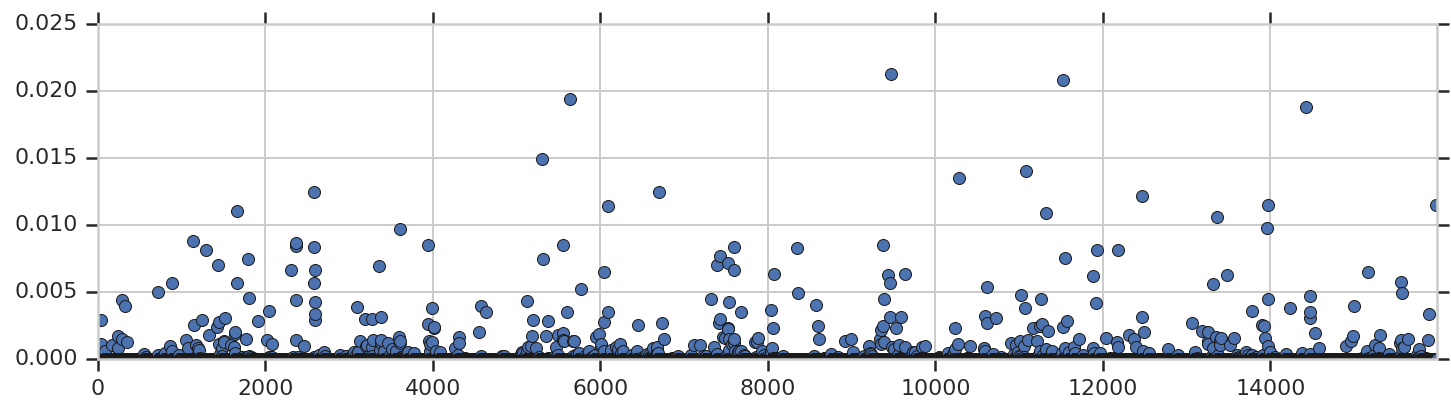

In [0]:
pd.Series(weights).plot(style='o', figsize=(12, 3))

The point estimate **`$1713`** is getting closer to the experimental benchmark **`$1794`**.

In [0]:
diff = treated["earnings1978"].mean() - np.sum(control["earnings1978"] * weights)
diff

1713.270

The 95% confidence interval becomes narrower due to increased effective control sample size.

In [0]:
sd = np.sqrt(treated["earnings1978"].var(ddof=1) *
             (1 / len(treated["earnings1978"]) + 1 / effective_control_size))
sd

641.958

In [0]:
(diff - 1.96 * sd, diff + 1.96 * sd)

(455.032, 2971.507)

### Imposing an Upper Bound on Weights

For both entropy balancing and quadratic balancing, one can optionally impose an upper bound on the weights to avoid extreme individual weights. For illustration, we impose an upper bound 0.015 on quadratic balancing weights, i.e., no single control individual accounts for 1.5% or more of total weights.

In [0]:
weights, success = ec.calibrate(
    covariates=control2.values,
    target_covariates=treated2.values,
    objective=ec.Objective.QUADRATIC,
    max_weight=0.015,
    l2_norm=1e-2)
success

True

We can confirm the resulting weights are indeed capped at 0.015.

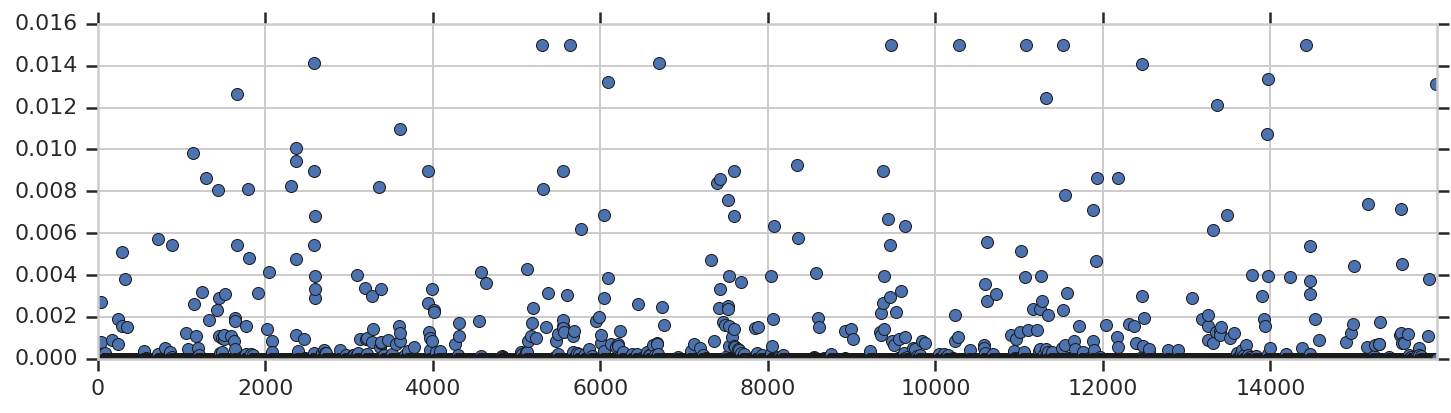

In [0]:
pd.Series(weights).plot(style='o', figsize=(12, 3))

The cost of this additional constraint is a small loss in effective sample size.

In [0]:
effective_control_size = 1.0 / np.square(weights).sum()
effective_control_size

146.060

Note that this additional weights constraint is an integral part of the optimization, as opposed to a separate trimming step used with propensity score weighting type method. We don't sacrifice the balancing conditions.

In [0]:
pd.concat([treated.mean(axis=0),
           pd.Series(np.matmul(control.astype('float64').T, weights),
                     index=treated.columns)], axis=1)

,0,1
treatment,1.000000,0.000000
age,25.816216,25.814217
education,10.345946,10.343364
black,0.843243,0.843853
hispanic,0.059459,0.059537
married,0.189189,0.191219
nodegree,0.708108,0.713018
earnings1974,2095.573689,2095.573688
earnings1975,1532.055314,1532.055313
earnings1978,6349.143530,4510.605801


The point estimate is very close to the experimental estimate **`$1794`**.

In [0]:
diff = treated["earnings1978"].mean() - np.sum(control["earnings1978"] * weights)
diff

1838.538